Test Welch's method vs. FFT

In [1]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch, psd_array_multitaper, tfr_array_multitaper, tfr_array_morlet
from scipy.signal import spectrogram
from scipy.signal import hilbert  # Apply Hilbert transform
from scipy.signal import butter, filtfilt, hilbert

In [2]:
rng = np.random.default_rng() 

# Generate a test signal with 2 Vrms sine wave at 1234 Hz, corrupted by 0.001 V^2/Hz of white noise sampled at 10 kHz
fs = 500
N = 1e5
amp = 2*np.sqrt(2)
freq = 10
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += rng.normal(scale=np.sqrt(noise_power), size=time.shape)

Display the signal in time domain

Estimate the power spectral density using FFT and Welch's methods

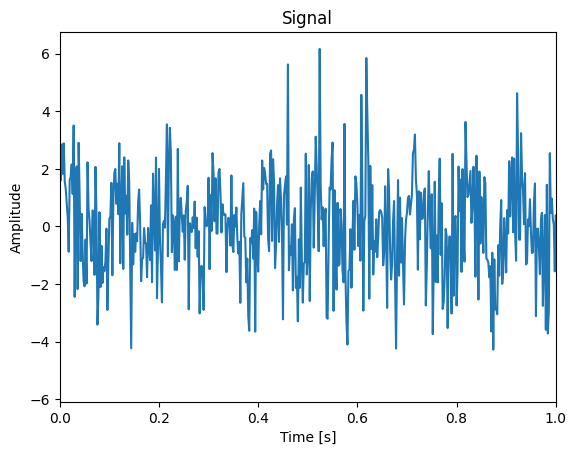

In [11]:
fs = 500  
T = 10     
t = np.linspace(0, T, int(fs * T), endpoint=False)
signal = (np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t) + 1.5*np.random.randn(len(t)))

plt.plot(t, signal)
plt.xlim([0, 1])
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

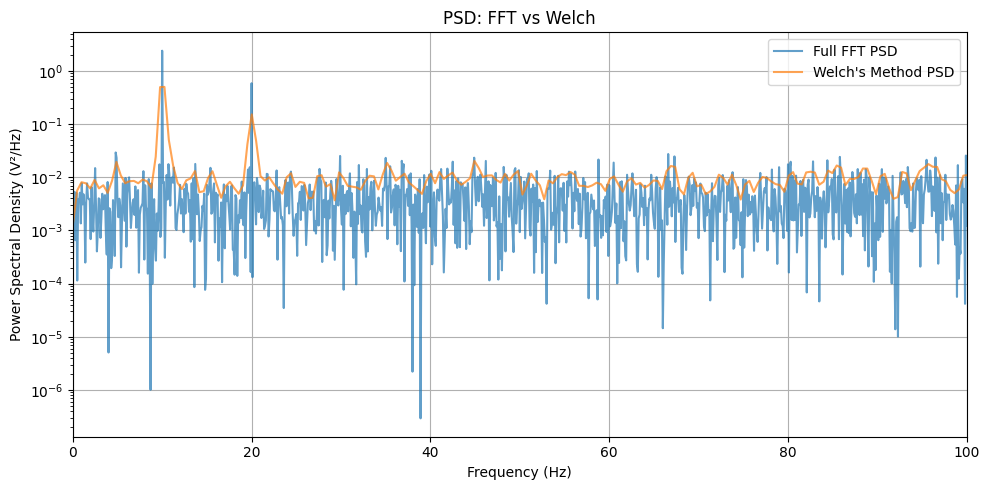

In [12]:
# -----------------------------
# Full FFT
# -----------------------------
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, 1/fs)

pos_mask = fft_freqs >= 0
fft_vals = fft_vals[pos_mask]
fft_freqs = fft_freqs[pos_mask]

# PSD: |FFT|^2 / (fs * N)
psd_fft = (np.abs(fft_vals) ** 2) / (fs * N)

# -----------------------------
# Welch's metthod
# -----------------------------
f_welch, psd_welch = welch(signal, fs=fs, nperseg=1024)

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(10, 5))
plt.semilogy(fft_freqs, psd_fft, label='Full FFT PSD', alpha=0.7)
plt.semilogy(f_welch, psd_welch, label="Welch's Method PSD", alpha=0.7)
plt.xlim([0, 100])
plt.title('PSD: FFT vs Welch')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

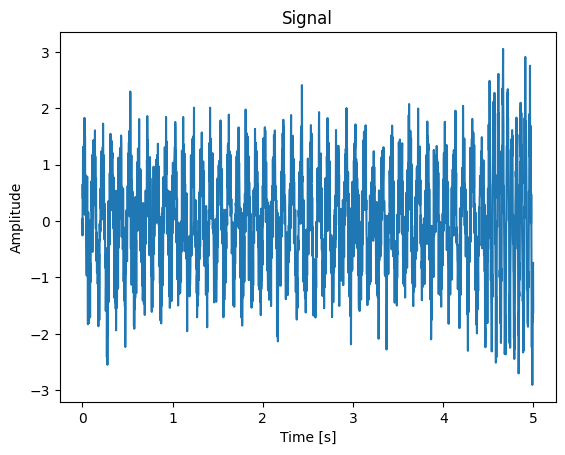

In [26]:
fs = 500
T = 5 
t = np.linspace(0, T, int(fs*T), endpoint=False)

# Non-stationary signal
signal = np.zeros_like(t)
signal[t < 4.5] = np.sin(2*np.pi*10*t[t < 4.5]) 
signal[t >= 4.5] = 2 * np.sin(2*np.pi*20*t[t >= 4.5])    
signal += 0.5 * np.random.randn(len(t))              

plt.plot(t, signal)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

    Using multitaper spectrum estimation with 9 DPSS windows


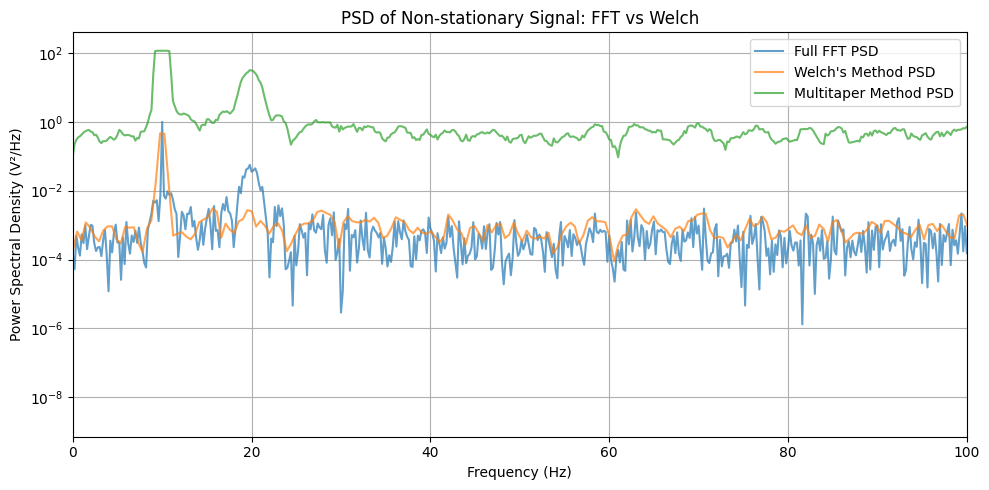

In [27]:
# Full FFT PSD
N = len(signal)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(N, 1/fs)
pos_mask = fft_freqs >= 0
psd_fft = (np.abs(fft_vals[pos_mask]) ** 2) / (fs * N)

# Welch PSD
f_welch, psd_welch = welch(signal, fs=fs, nperseg=1024)

# Multitaper PSD
fmin, fmax = 0, fs/2
psd_mt, f_mt = psd_array_multitaper(signal, sfreq=fs, fmin=fmin, fmax=fmax, bandwidth=2.0)

# Visualization
plt.figure(figsize=(10, 5))
plt.semilogy(fft_freqs[pos_mask], psd_fft, label='Full FFT PSD', alpha=0.7)
plt.semilogy(f_welch, psd_welch, label="Welch's Method PSD", alpha=0.7)
plt.semilogy(f_mt, psd_mt, label="Multitaper Method PSD", alpha=0.7)
plt.title('PSD of Non-stationary Signal: FFT vs Welch')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.xlim([0, 100])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [35]:
fs = 250
t = np.linspace(0, 5, fs * 5, endpoint=False)
sig = np.zeros_like(t)

# 0-2 sec: 10 Hz
sig[(t >= 0) & (t < 2)] = np.sin(2 * np.pi * 10 * t[(t >= 0) & (t < 2)])

# 2-4 sec: 10 Hz + 12 Hz Test frequency separation
idx = (t >= 2) & (t < 4)
sig[idx] = (np.sin(2 * np.pi * 10 * t[idx]) +
            0.8 * np.sin(2 * np.pi * 12 * t[idx]))

# 4-5 sec: 35 Hz burst Test high-frequency component
idx = (t >= 4) & (t < 5)
sig[idx] = 0.6 * np.sin(2 * np.pi * 35 * t[idx])

# Add noise
sig += 0.2 * np.random.randn(len(t))

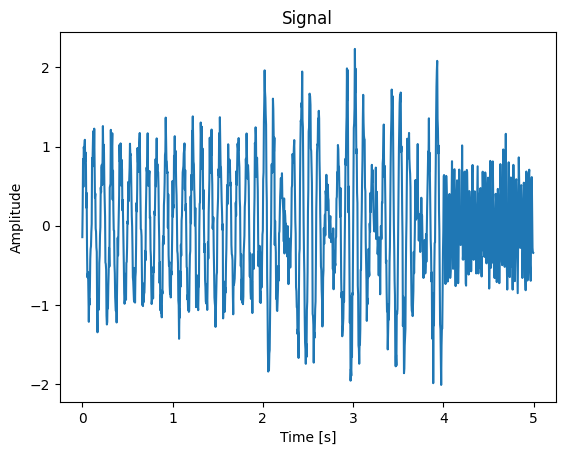

In [33]:
plt.plot(t, sig)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

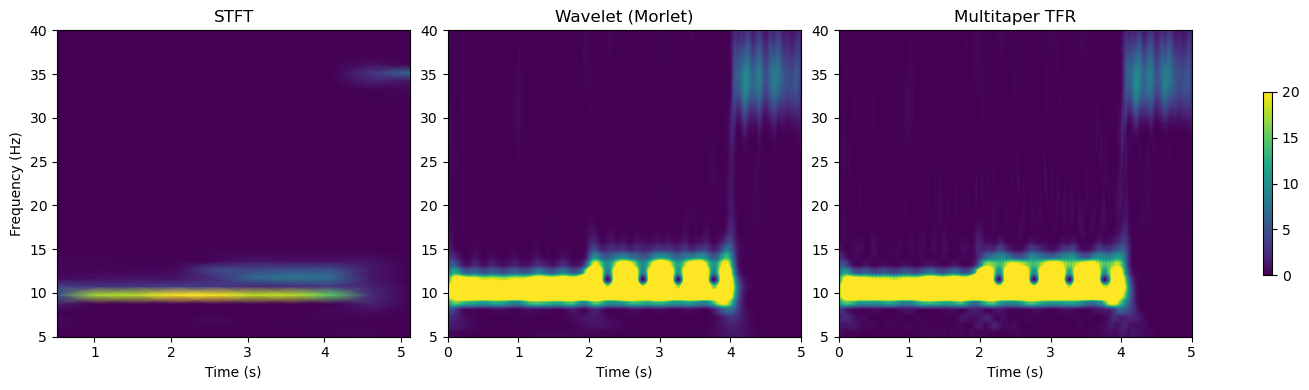

In [ ]:
# --------------------------
# Time-Frequency analysis with created signal
# --------------------------

# shape: (n_epochs, n_channels, n_times)
data = sig[np.newaxis, np.newaxis, :]

# STFT (scipy)
pad = 128  # half window
sig_padded = np.pad(sig, pad_width=pad, mode='constant')
f_stft, t_stft, Sxx = spectrogram(sig_padded, fs=fs, nperseg=256, noverlap=128)

# Morlet Wavelet
freqs_wavelet = np.linspace(5, 40, 40)
n_cycles = 8 #freqs_wavelet / 2.  # Temporal resolution relative to frequency
power_wavelet = tfr_array_morlet(data, sfreq=fs, freqs=freqs_wavelet,
                                  n_cycles=n_cycles, output='power', zero_mean=True)[0, 0]

# Multitaper TFR
power_mt = tfr_array_multitaper(data, sfreq=fs, freqs=freqs_wavelet,
                                n_cycles=5, output='power', time_bandwidth=2)[0, 0]

# --------------------------
# Visualization
# --------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# STFT
axs[0].pcolormesh(t_stft, f_stft, Sxx, shading='gouraud', vmin=0, vmax=0.45)
axs[0].set_title('STFT')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylim([5, 40])


# Wavelet
im = axs[1].imshow(power_wavelet, aspect='auto', origin='lower',
                   extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[1].set_title('Wavelet (Morlet)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylim([5, 40])

# Multitaper TFR
axs[2].imshow(power_mt, aspect='auto', origin='lower',
              extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[2].set_title('Multitaper TFR')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylim([5, 40])


plt.tight_layout()
plt.colorbar(im, ax=axs, shrink=0.6)
plt.show()

Test with more dynamic signal

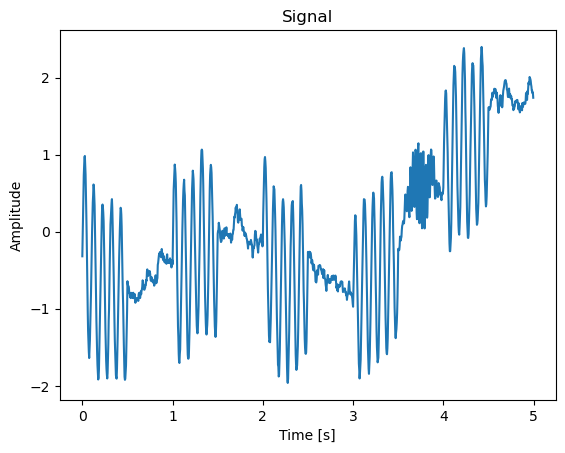

In [105]:
sig = np.load("semi_realistic_eeg_signal.npy")
fs = 250
t = np.linspace(0, len(sig) / fs, len(sig), endpoint=False)

plt.plot(t, sig)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

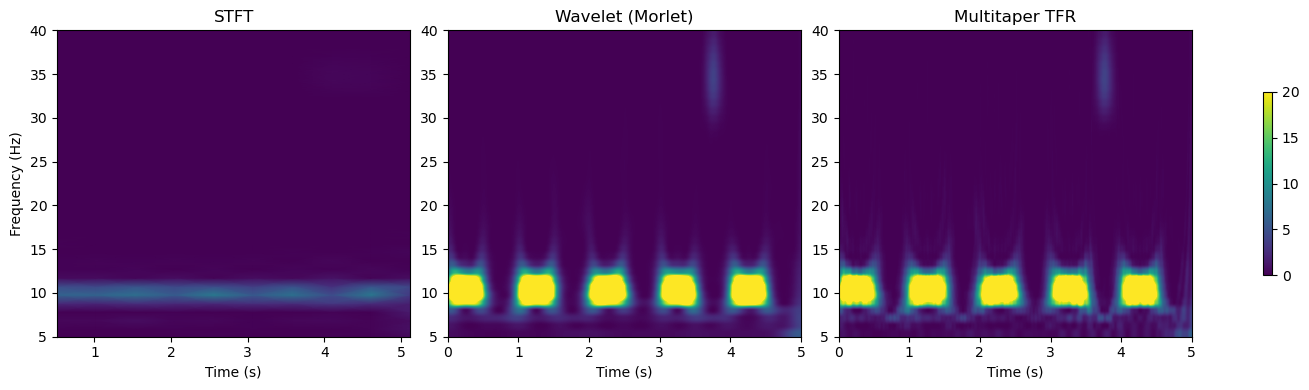

In [106]:
# --------------------------
# Time-Frequency analysis with created signal
# --------------------------

# (n_epochs, n_channels, n_times)
data = sig[np.newaxis, np.newaxis, :]

# STFT (scipy)
pad = 128  # half window
sig_padded = np.pad(sig, pad_width=pad, mode='constant')
f_stft, t_stft, Sxx = spectrogram(sig_padded, fs=fs, nperseg=256, noverlap=128)

# Morlet Wavelet
freqs_wavelet = np.linspace(5, 40, 40)
n_cycles = 8 #freqs_wavelet / 2.  # Temporal resolution relative to frequency
power_wavelet = tfr_array_morlet(data, sfreq=fs, freqs=freqs_wavelet,
                                  n_cycles=n_cycles, output='power', zero_mean=True)[0, 0]

# Multitaper TFR
power_mt = tfr_array_multitaper(data, sfreq=fs, freqs=freqs_wavelet,
                                n_cycles=5, output='power', time_bandwidth=2)[0, 0]

# --------------------------
# Visualization
# --------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# STFT
axs[0].pcolormesh(t_stft, f_stft, Sxx, shading='gouraud', vmin=0, vmax=0.45)
axs[0].set_title('STFT')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylim([5, 40])


# Wavelet
im = axs[1].imshow(power_wavelet, aspect='auto', origin='lower',
                   extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[1].set_title('Wavelet (Morlet)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylim([5, 40])

# Multitaper TFR
axs[2].imshow(power_mt, aspect='auto', origin='lower',
              extent=[0, 5, freqs_wavelet[0], freqs_wavelet[-1]], vmin=0, vmax=20)
axs[2].set_title('Multitaper TFR')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylim([5, 40])


plt.tight_layout()
plt.colorbar(im, ax=axs, shrink=0.6)
plt.show()

## Test Phase locking value

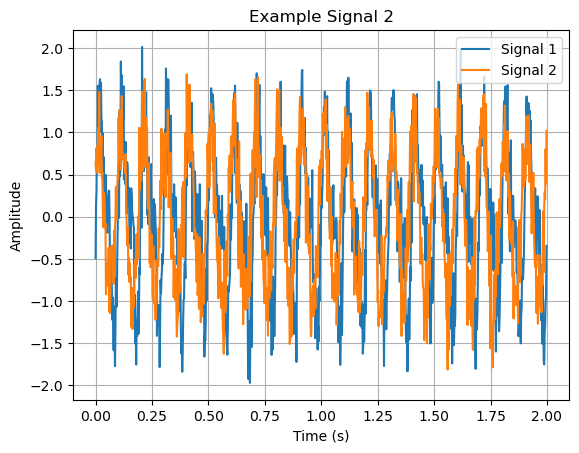

In [30]:
# Simulation parameters
fs = 500  # Sampling frequency  # Sampling frequency in Hz
t = np.arange(0, 2, 1/fs)  # 2 seconds  # Time vector for simulation
n_trials = 100  # Number of trials (simulated repetitions)

# Base signal: mixture of 10Hz and 20Hz with noise
signal = np.array([np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t) + 0.3*np.random.randn(len(t)) for _ in range(n_trials)])  # Number of trials (simulated repetitions)
phi_diff = np.pi / 4
signal2 = np.array([np.sin(2*np.pi*10*t + phi_diff) + 0.3*np.random.randn(len(t)) for _ in range(n_trials)])  # Number of trials (simulated repetitions)

# Plot one trial of signal 1
plt.plot(t, signal[0])
plt.title("Example Signal")

# Plot one trial of signal 2
plt.plot(t, signal2[0])
plt.title("Example Signal 2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(["Signal 1", "Signal 2"])
plt.show()

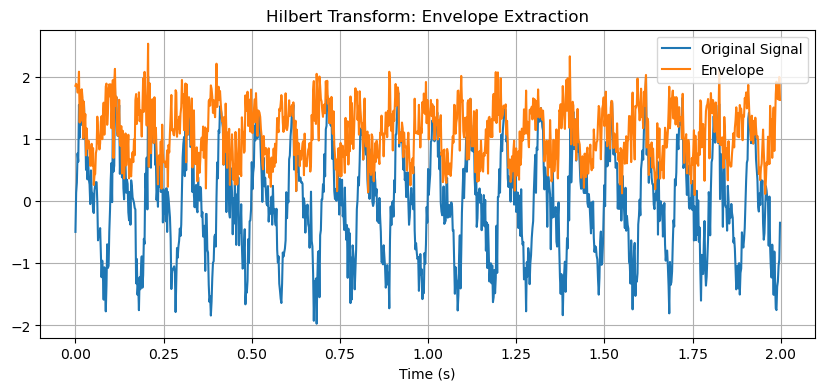

In [31]:
from scipy.signal import hilbert  # Apply Hilbert transform

analytic_signal = hilbert(signal[0])  # Apply Hilbert transform
amplitude_envelope = np.abs(analytic_signal)  # Extract instantaneous amplitude
instantaneous_phase = np.angle(analytic_signal)  # Extract instantaneous phase

plt.figure(figsize=(10, 4))
plt.plot(t, signal[0], label='Original Signal')
plt.plot(t, amplitude_envelope, label='Envelope')  # Extract instantaneous amplitude
plt.title("Hilbert Transform: Envelope Extraction")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()


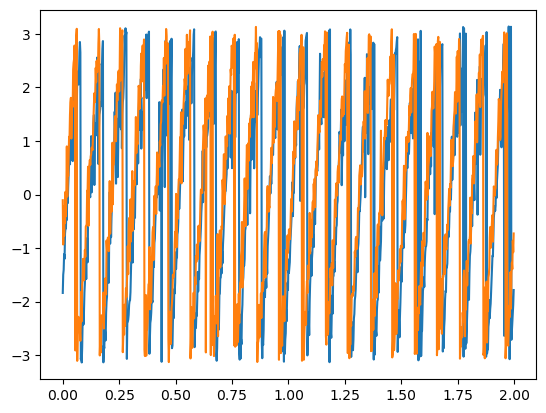

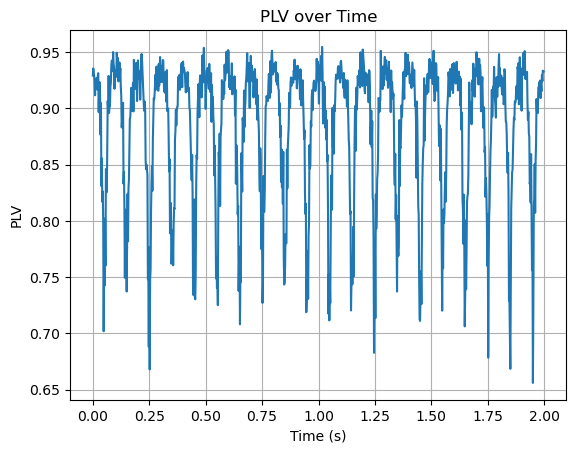

In [32]:
def compute_phase(data):  # Define helper function to extract phase using Hilbert
    return np.angle(hilbert(data, axis=1))  # Apply Hilbert transform

phase1 = compute_phase(signal)  # Define helper function to extract phase using Hilbert
phase2 = compute_phase(signal2)  # Define helper function to extract phase using Hilbert

plt.plot(t, phase1[0], label='Phase 1')
plt.plot(t, phase2[0], label='Phase 2')
plt.show()

phase_diff = phase1 - phase2
plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))  # Compute PLV from phase difference

plt.plot(t, plv)
plt.title("PLV over Time")
plt.xlabel("Time (s)")
plt.ylabel("PLV")
plt.grid(True)
plt.show()

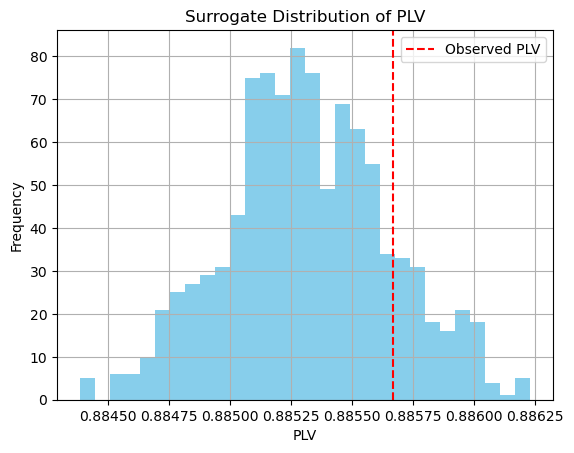

P-value: 0.1530


In [33]:
n_surrogates = 1000
plv_surrogates = []

for _ in range(n_surrogates):
    shift = np.random.randint(len(t))
    shuffled = np.roll(phase2, shift, axis=1)  # Create surrogate data by circular phase shifting
    diff = phase1 - shuffled
    surrogate_plv = np.abs(np.mean(np.exp(1j * diff), axis=0))
    plv_surrogates.append(np.mean(surrogate_plv))

plv_surrogates = np.array(plv_surrogates)
mean_plv_obs = np.mean(plv)

plt.hist(plv_surrogates, bins=30, color='skyblue')  # Plot histogram of surrogate PLVs
plt.axvline(mean_plv_obs, color='red', linestyle='--', label='Observed PLV')
plt.title("Surrogate Distribution of PLV")
plt.xlabel("PLV")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

p_val = np.mean(plv_surrogates >= mean_plv_obs)  # Calculate p-value based on surrogate distribution
print(f"P-value: {p_val:.4f}")  # Calculate p-value based on surrogate distribution


986


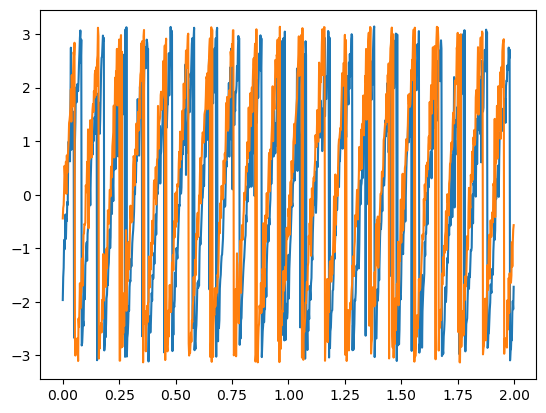

In [27]:
print(shift)
plt.plot(t, phase1[0], label='Phase 1')
plt.plot(t, shuffled[0], label='Shuffled')
plt.show()

## Hibert transform and band-pass filtering

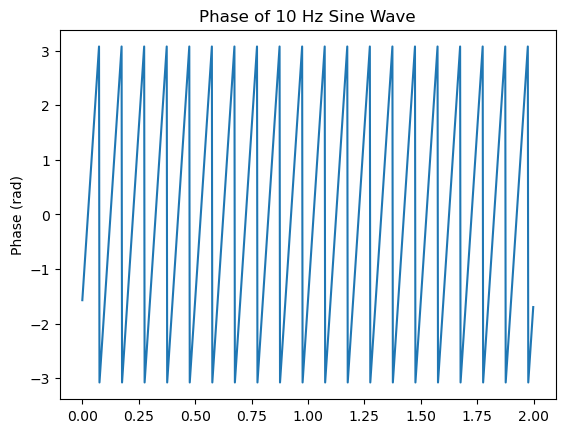

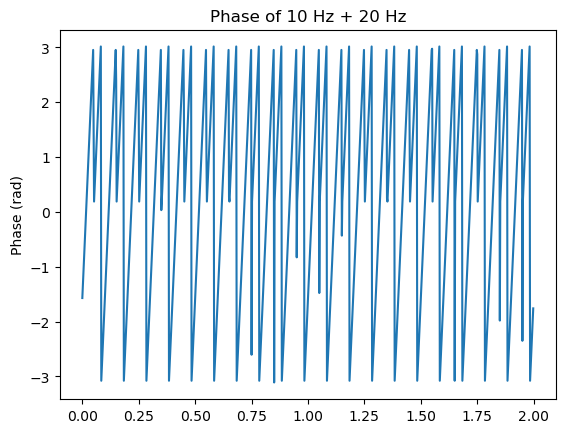

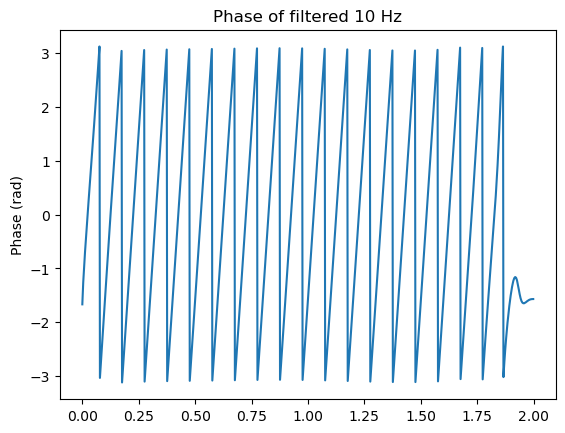

In [38]:
# Simulation parameters
fs = 500  # Sampling frequency in Hz
t = np.arange(0, 2, 1/fs)  # 2-second time vector

# Case 1: Pure 10 Hz sine wave
x1 = np.sin(2 * np.pi * 10 * t)
analytic1 = hilbert(x1)
phase1 = np.angle(analytic1)

# Case 2: Mixture of 10 Hz and 20 Hz
x2 = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
analytic2 = hilbert(x2)
phase2 = np.angle(analytic2)

# Case 3: Bandpass filtered (extracting 10 Hz component from the mixture)
def bandpass(sig, low, high, fs, order=4):
    b, a = butter(order, [low, high], btype='band', fs=fs)
    return filtfilt(b, a, sig)

x2_filtered = bandpass(x2, 9, 11, fs)  # Filter around 10 Hz
analytic3 = hilbert(x2_filtered)
phase3 = np.angle(analytic3)


plt.plot(t, phase1)
plt.ylabel('Phase (rad)')
plt.title("Phase of 10 Hz Sine Wave")
plt.show()

plt.plot(t, phase2)
plt.title('Phase of 10 Hz + 20 Hz')
plt.ylabel('Phase (rad)')
plt.show()

plt.plot(t, phase3)
plt.title('Phase of filtered 10 Hz')
plt.ylabel('Phase (rad)')
plt.show()
